# Part 1: Exploratory Data Analysis (EDA)

In [7]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Subset
from torchviz import make_dot
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import make_grid

from torchinfo import summary

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Load Data

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5,), std=(0.5,))]) #transform the numpy array to tensor and normalize the data
mnist_dataset = datasets.MNIST(root='./data_src', train=True, download=True, transform=transform) #load train set
mnist_test_dataset = datasets.MNIST(root='./data_src', train=False, download=True, transform=transform) #load test set

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 39.5MB/s]


Extracting ./data_src/MNIST/raw/train-images-idx3-ubyte.gz to ./data_src/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.41MB/s]

Extracting ./data_src/MNIST/raw/train-labels-idx1-ubyte.gz to ./data_src/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 9.37MB/s]


Extracting ./data_src/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data_src/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.64MB/s]

Extracting ./data_src/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data_src/MNIST/raw



In [ ]:
# Load Fashion-MNIST datasets
fashion_mnist = datasets.FashionMNIST(root='./data_src', train=True, download=True, transform=transform)
fashion_mnist_test = datasets.FashionMNIST(root='./data_src', train=False, download=True, transform=transform)

## Preview Data

In [ ]:
def preview(dataset, dataset_name, num_samples=3):
    plt.figure(figsize=(6, 3))

    for i in range(num_samples):
        image, label = dataset[i]  # extract image and label
        image = image.numpy().squeeze()  # convert tensor to NumPy array

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Label: {label}")
        plt.axis('off')

    plt.suptitle(f"Preview of {dataset_name}")
    plt.show()

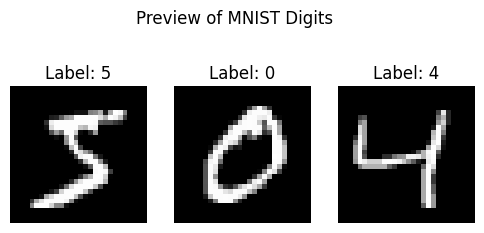

In [ ]:
preview(mnist_dataset, "MNIST Digits")

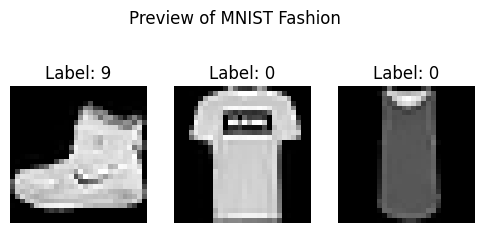

In [ ]:
preview(fashion_mnist, "MNIST Fashion")

## Dataset Analysis

In [ ]:
# a) Number of samples
digits_samples = mnist_dataset.data.shape[0]+mnist_test_dataset.data.shape[0]
print(f'Total samples in MNIST digits dataset: {digits_samples} \nDivision:\n\tTraining data: {mnist_dataset.data.shape[0]} \n\tTesting Data: {mnist_test_dataset.data.shape[0]}')

fashion_samples = fashion_mnist.data.shape[0]+fashion_mnist_test.data.shape[0]
print(f'\n\nTotal samples in MNIST Fashion dataset: {fashion_samples} \nDivision:\n\tTraining data: {fashion_mnist.data.shape[0]} \n\tTesting Data: {fashion_mnist_test.data.shape[0]}')

Total samples in MNIST digits dataset: 70000 
Division:
	Training data: 60000 
	Testing Data: 10000


Total samples in MNIST Fashion dataset: 70000 
Division:
	Training data: 60000 
	Testing Data: 10000


In [ ]:
# b) number of classes and unique labels
print(f"Number of classes in MNIST Digits: {len(torch.unique(mnist_dataset.targets))} \n\tLabels: {torch.unique(mnist_dataset.targets).numpy()}")

print(f"\n\nNumber of classes in MNIST Fashion: {len(torch.unique(fashion_mnist.targets))} \n\tLabels: {torch.unique(fashion_mnist_test.targets).numpy()}")

Number of classes in MNIST Digits: 10 
	Labels: [0 1 2 3 4 5 6 7 8 9]


Number of classes in MNIST Fashion: 10 
	Labels: [0 1 2 3 4 5 6 7 8 9]


# Part 2: Implementing Generative Adversarial Networks (GANs)

## MNIST Digits Data

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dimension=110):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(10, 10)  #converts labels(0-9) to embedding
        self.generator = nn.Sequential(
            nn.Linear(110, 128),  #100 (noise) + 10 (one-hot label)
            nn.LeakyReLU(0.2), #scales negative values by 0.2
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512,1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 28*28),
            nn.Tanh() #normalized to the range [-1, 1]
        )

    def forward(self, z, labels):
        y = self.label_emb(labels)  # convert labels to embedding
        x = torch.cat((z, y), dim=1)  #concatenate noise and label
        x = self.generator(x)
        x = x.view(x.size(0), 1, 28, 28) #convert [batch_size,28*28] to gray scale image of shape [batch_size,1,28,28]
        return x


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, num_classes=10):
        super(Discriminator, self).__init__()

        self.label_embedding = nn.Embedding(num_classes, 10)  #convert label(0-9) to embedding

        self.discriminator = nn.Sequential(
            nn.Linear(28*28 + 10, 1024),  # Image (784) + Label Embedding (10)
            nn.LeakyReLU(0.2), #scales negative values by 0.2
            nn.Dropout(0.4),  #to prevent overfitting
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.Linear(256,128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.Linear(128, 1),
            nn.Sigmoid()  #binary classification: real(1) or fake(0)
        )

    def forward(self, images, labels):
        batch_size = images.shape[0]
        images = images.view(batch_size, -1)  #flatten images from [batch_size, 1, 28, 28] to [batch_size, 28*28]
        label_embedding = self.label_embedding(labels.long())
        x = torch.cat((images, label_embedding), dim=1)  #concat image and label -> [batch_size, 794]
        return self.discriminator(x) #outputs real(1) or fake(0)

In [ ]:
def discriminator_training(real_images, real_labels, fake_images, fake_labels, model, optimizer):
    optimizer.zero_grad() #reset gradients

    real_preds = model(real_images, real_labels)  # D(real_images, real_labels)
    fake_preds = model(fake_images, fake_labels)  # D(fake_images, fake_labels)

    loss = -(torch.mean(torch.log(real_preds)) + torch.mean(torch.log(1 - fake_preds)))
    loss.backward() #compute gradients
    optimizer.step() #update weights

    return loss

In [ ]:
def generator_training(fake_images, fake_labels, discriminator, optimizer):
    optimizer.zero_grad() #reset gradients

    fake_preds = discriminator(fake_images, fake_labels)  # D(G(z), labels)

    loss = -torch.mean(torch.log(fake_preds))

    loss.backward() #compute gradients
    optimizer.step() #update generator's weights

    return loss

In [ ]:
torch.manual_seed(111) #for cpu
torch.cuda.manual_seed(111) #for gpu
np.random.seed(111)

In [ ]:
def train_CGAN(epochs,discriminator_loss,generator_loss, data_loader, discriminator, generator, d_optimizer, g_optimizer, device):
    for epoch in range(epochs):
        discriminator_losses, generator_losses = [], []  #to store per batch loss

        for real_images, labels in tqdm(data_loader):
            batch_size = real_images.shape[0]

            #move tensors to the same device
            real_images = real_images.to(device)
            labels = labels.to(device)

            #generate noise and fake images
            noise = torch.randn(batch_size, 100).to(device)
            fake_images = generator(noise, labels).to(device)

            #detach fake images from graph for discriminator training
            fake_images_detached = fake_images.detach()

            # Train discriminator
            discrim_batch_loss = discriminator_training(real_images,labels, fake_images_detached, labels, discriminator, d_optimizer)
            discriminator_losses.append(discrim_batch_loss.item())

            # Train generator
            fake_images = generator(noise, labels).to(device)
            gen_batch_loss = generator_training(fake_images, labels, discriminator, g_optimizer)
            generator_losses.append(gen_batch_loss.item())

        discriminator_loss.append(np.array(discriminator_losses).mean())
        generator_loss.append(np.array(generator_losses).mean())

        if (epoch + 1) % 10 == 0:
            print(f"Epoch: {epoch+1}/{epochs} - Discriminator loss: {discriminator_loss[-1]:.4f} - Generator loss: {generator_loss[-1]:.4f}")

In [ ]:
epochs = 50
discriminator = Discriminator().to(device)
generator = Generator().to(device)

d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

data_loader = DataLoader(mnist_dataset, batch_size=128, shuffle=True, drop_last=True) #to make random batches of data

discriminator_loss, generator_loss = [], []  #to store per epoch loss

train_CGAN(epochs,discriminator_loss,generator_loss, data_loader, discriminator, generator, d_optimizer, g_optimizer, device)

100%|██████████| 468/468 [00:16<00:00, 28.23it/s]


Epoch: 10/50 - Discriminator loss: 0.4316 - Generator loss: 3.3291


100%|██████████| 468/468 [00:15<00:00, 29.72it/s]


Epoch: 20/50 - Discriminator loss: 0.6800 - Generator loss: 2.3026


100%|██████████| 468/468 [00:15<00:00, 29.88it/s]


Epoch: 30/50 - Discriminator loss: 0.8880 - Generator loss: 1.6733


100%|██████████| 468/468 [00:16<00:00, 28.60it/s]


Epoch: 40/50 - Discriminator loss: 1.0132 - Generator loss: 1.3887


100%|██████████| 468/468 [00:15<00:00, 29.69it/s]

Epoch: 50/50 - Discriminator loss: 1.1212 - Generator loss: 1.1565


### Loss Curves

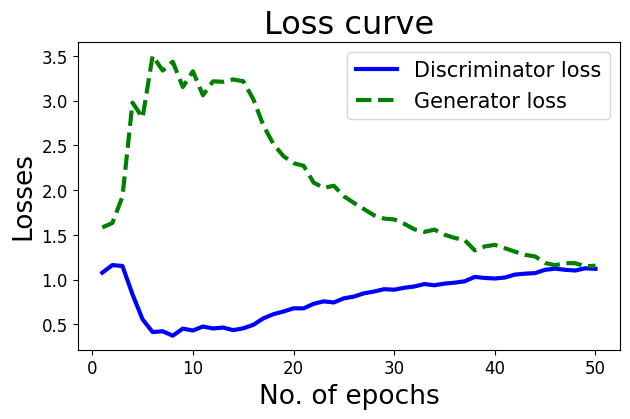

In [ ]:
N = np.arange(epochs) + 1

plt.figure(figsize=(7, 4))
plt.plot(N, discriminator_loss, 'b-', linewidth=3, label='Discriminator loss')
plt.plot(N, generator_loss, 'g--', linewidth=3, label='Generator loss')
plt.title('Loss curve', fontsize=23)
plt.xlabel('No. of epochs', fontsize=19)
plt.ylabel('Losses', fontsize=19)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=15)

### 10 images for MNIST Digits data

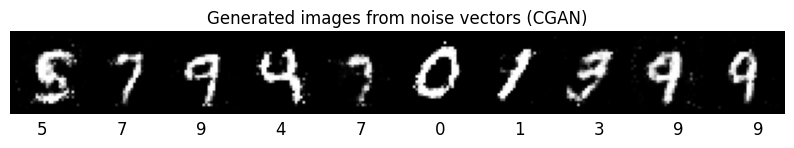

In [ ]:
generator.eval()

#generate random noise and labels
n = torch.randn(10, 100)  #noise vector
labels = torch.randint(0, 10, (10,))  #random labels (0-9)
labels = labels.long()

n = n.cpu()
labels = labels.cpu()

#generate images
with torch.no_grad():
    random_samples = generator.cpu()(n, labels)

#reshape and normalize
random_samples = random_samples.view(10, 1, 28, 28)
grid = make_grid(random_samples, nrow=10, normalize=True)

plt.figure(figsize=(10, 5))
plt.imshow(grid.permute(1, 2, 0), cmap='gray')
plt.axis(False)
plt.title('Generated images from noise vectors (CGAN)')

labels_list = labels.tolist()

for i, label in enumerate(labels_list):
    plt.text(i * 31 + 10, 34, str(label), fontsize=12, va='top')

plt.show()


### Images with last roll numdigit i.e '1'

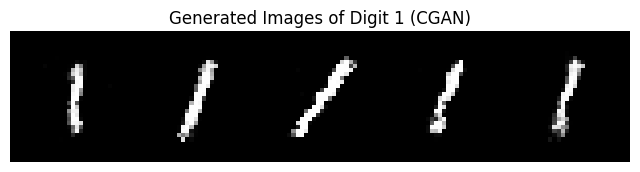

In [ ]:
generator.eval()

#generate random noise
n = torch.randn(5, 100)
labels = torch.ones(5, dtype=torch.long)

n = n.cpu()
labels = labels.cpu()

#generate images with label=1
with torch.no_grad():
    random_samples = generator.cpu()(n, labels)

random_samples = random_samples.view(5, 1, 28, 28)
grid = make_grid(random_samples, nrow=10, normalize=True)

plt.figure(figsize=(8, 2))
plt.imshow(grid.permute(1, 2, 0), cmap='gray')
plt.axis(False)
plt.title('Generated Images of Digit 1 (CGAN)')
plt.show()


## Fashion MNIST data

In [ ]:
class DISCRIMINATOR(nn.Module):
    def __init__(self):
        super(DISCRIMINATOR, self).__init__()

        self.discriminator = nn.Sequential(
            nn.Linear(in_features=28*28, out_features=1024),
            nn.ReLU(),
            nn.Dropout(p=0.3), #to prevent overfitting
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(in_features=256, out_features=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.shape[0], -1) #flatten images from [batch_size, 1, 28, 28] to [batch_size, 28*28]
        x = self.discriminator(x) #outputs real(1) or fake(0)
        return x

In [ ]:
class GENERATOR(nn.Module):
    def __init__(self):
        super(GENERATOR, self).__init__()

        self.generator = nn.Sequential(
            nn.Linear(in_features=100, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=28*28),
            nn.Tanh()#normalize output to [-1,1]
        )

    def forward(self, x):
        x = self.generator(x)
        return x

In [ ]:
def random_noise(batch_size):
    noise = torch.randn(batch_size, 100)
    return noise

In [ ]:
def discriminator_train(real_images, fake_images, model, optimizer):
    optimizer.zero_grad()  #reset gradients

    real_preds = model(real_images)  # D(real_data)
    fake_preds = model(fake_images)  # D(fake_data)

    #BCE loss
    loss = -(torch.mean(torch.log(real_preds)) + torch.mean(torch.log(1 - fake_preds)))

    loss.backward()  #compute gradients
    optimizer.step()  #update weights

    return loss.item()


In [ ]:
def generator_train(fake_images,discriminator, optimizer):
    optimizer.zero_grad()  #reset gradients

    fake_preds = discriminator(fake_images) # D(fake_data)

    loss = -torch.mean(torch.log(fake_preds)) #BCE loss

    loss.backward() #compute gradients
    optimizer.step() #update weights

    return loss.item()


In [ ]:
torch.manual_seed(111)
torch.cuda.manual_seed(111)
torch.cuda.manual_seed_all(111)
np.random.seed(111)

In [ ]:
def train_GAN(epochs,discriminator_loss,generator_loss, data_loader, discriminator, generator, d_optimizer, g_optimizer, device):
    for epoch in range(epochs):
        discriminator_losses, generator_losses = [], []

        for data, _ in tqdm(data_loader):

            real_images = data.to(device)
            #generate fake data from noise
            fake_images = generator(random_noise(batch_size=128).to(device)).to(device)
            #detach from graph
            fake_images = fake_images.detach()

            discrim_batch_loss = discriminator_train(real_images, fake_images, discriminator, d_optimizer)
            discriminator_losses.append(discrim_batch_loss)

            fake_images = generator(random_noise(batch_size=128).to(device)).to(device)
            generator_batch_loss = generator_train(fake_images, discriminator, g_optimizer)
            generator_losses.append(generator_batch_loss)

        discriminator_per_epoch_loss = np.array(discriminator_losses).mean()
        generator_per_epoch_loss = np.array(generator_losses).mean()

        discriminator_loss.append(discriminator_per_epoch_loss)
        generator_loss.append(generator_per_epoch_loss)

        if (epoch+1) % 10 == 0:
            print(f"Epoch: {epoch+1}/{epochs} - Discriminator loss: {discriminator_loss[-1]:.4f} - Generator loss: {generator_loss[-1]:.4f}")

In [ ]:
epochs = 100
discriminator_fashion = DISCRIMINATOR().to(device)
generator_fashion = GENERATOR().to(device)

d_optimizer2 = optim.Adam(discriminator_fashion.parameters(), lr=0.0001)
g_optimizer2 = optim.Adam(generator_fashion.parameters(), lr=0.0001)

#filtering dataset to keep only "Ankle Boot" class (label 9)
shoe_indices = [i for i, label in enumerate(fashion_mnist.targets) if label == 9]
shoe_dataset = Subset(fashion_mnist, shoe_indices)

data_loader_fashion = DataLoader(shoe_dataset, batch_size=64, shuffle=True, drop_last=True)

discriminator_loss_fashion, generator_loss_fashion = [], []  #to store per epoch loss

train_GAN(epochs,discriminator_loss_fashion,generator_loss_fashion, data_loader_fashion, discriminator_fashion, generator_fashion, d_optimizer2, g_optimizer2, device)

100%|██████████| 93/93 [00:01<00:00, 52.02it/s]


Epoch: 10/100 - Discriminator loss: 0.0451 - Generator loss: 5.6852


100%|██████████| 93/93 [00:01<00:00, 49.72it/s]


Epoch: 20/100 - Discriminator loss: 0.1365 - Generator loss: 5.8660


100%|██████████| 93/93 [00:01<00:00, 51.49it/s]


Epoch: 30/100 - Discriminator loss: 0.1190 - Generator loss: 5.9473


100%|██████████| 93/93 [00:01<00:00, 50.86it/s]


Epoch: 40/100 - Discriminator loss: 0.2211 - Generator loss: 4.1219


100%|██████████| 93/93 [00:02<00:00, 45.60it/s]


Epoch: 50/100 - Discriminator loss: 0.3123 - Generator loss: 3.7041


100%|██████████| 93/93 [00:01<00:00, 51.14it/s]


Epoch: 60/100 - Discriminator loss: 0.4118 - Generator loss: 3.1818


100%|██████████| 93/93 [00:02<00:00, 43.65it/s]


Epoch: 70/100 - Discriminator loss: 0.5273 - Generator loss: 2.7948


100%|██████████| 93/93 [00:01<00:00, 50.20it/s]


Epoch: 80/100 - Discriminator loss: 0.5677 - Generator loss: 2.4894


100%|██████████| 93/93 [00:01<00:00, 50.49it/s]


Epoch: 90/100 - Discriminator loss: 0.7036 - Generator loss: 2.0298


100%|██████████| 93/93 [00:01<00:00, 47.28it/s]

Epoch: 100/100 - Discriminator loss: 0.8955 - Generator loss: 1.5587


### Loss Curvers

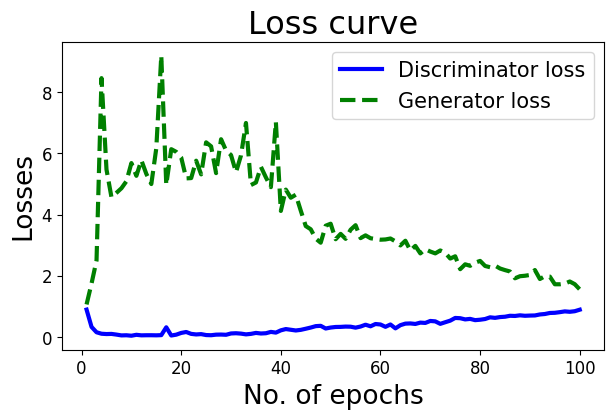

In [ ]:
N = np.arange(epochs) + 1

plt.figure(figsize=(7, 4))
plt.plot(N, discriminator_loss_fashion, 'b-', linewidth=3, label='Discriminator loss')
plt.plot(N, generator_loss_fashion, 'g--', linewidth=3, label='Generator loss')
plt.title('Loss curve', fontsize=23)
plt.xlabel('No. of epochs', fontsize=19)
plt.ylabel('Losses', fontsize=19)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=15)

### Shoe Images

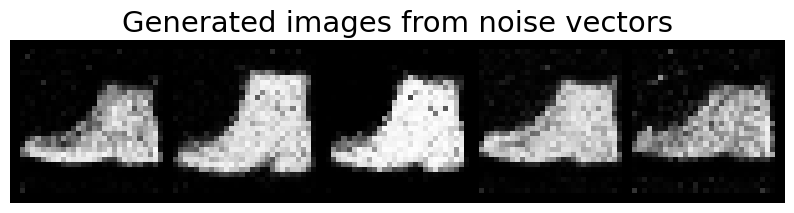

In [ ]:
generator_fashion.eval()
n = torch.randn(5, 100)
random_samples = generator_fashion.cpu()(n).view(5, 1, 28, 28)
grid = make_grid(random_samples, nrow=16, normalize=True)
plt.figure(figsize=(10, 4))
plt.imshow(grid.permute(1, 2, 0))
plt.axis(False)
plt.title('Generated images from noise vectors', fontsize=21)
plt.show()

# Part 3: Implementing Variational Autoencoder (VAE)

In [19]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import torch.optim as optim
import os


In [20]:
class VAE(nn.Module):

    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )

        # latent mean and variance
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )

    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar

In [21]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='mean')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

## Function to generate images

In [22]:
def generate_image(model, digit, latent_dict, mean_type='average'): #latent_dict: Stored latent vectors for each digit, mean_type: 'average' (mean of stored vectors) or 'random' (random latent vector)
    if digit not in latent_dict:
        print("Invalid digit selected.")
        return

    if mean_type == 'average':
        z_sample = np.mean(latent_dict[digit], axis=0)  #mean of stored vectors
    else:
        z_sample = latent_dict[digit][np.random.randint(len(latent_dict[digit]))]  #random vector

    z_sample = torch.tensor([z_sample], dtype=torch.float32).to(device) #convert latent vaector to tensor

    with torch.no_grad():
        x_decoded = model.decode(z_sample)

    digit_img = x_decoded[0].cpu().detach().numpy().reshape(28, 28)

    plt.imshow(digit_img, cmap='gray')
    plt.axis('off')
    plt.title(f"Generated Label: {digit}")
    plt.show()


## MNIST Digits

In [24]:
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

data = MNIST('./mnist_data', transform=transform, download=True)

loader = DataLoader(dataset=data, batch_size=100, shuffle=True, num_workers=20)

In [26]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train(model, optimizer, epochs, x_dim=784):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(loader):
            x = x.view(100, x_dim).to(device) #reshapes x from [batch_size, 1, 28, 28] to [batch_size, 784]

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)

            overall_loss += loss.item()

            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss / len(loader.dataset))


train(model, optimizer, epochs=50)


	Epoch 1 	Average Loss:  0.0028489260291059814
	Epoch 2 	Average Loss:  0.0026358292343715826
	Epoch 3 	Average Loss:  0.0026343185735245547
	Epoch 4 	Average Loss:  0.002613364914059639
	Epoch 5 	Average Loss:  0.0024379550188779833
	Epoch 6 	Average Loss:  0.0023933814138174057
	Epoch 7 	Average Loss:  0.002314714478701353
	Epoch 8 	Average Loss:  0.002215053571263949
	Epoch 9 	Average Loss:  0.0021739514261484147
	Epoch 10 	Average Loss:  0.0021357758129636447
	Epoch 11 	Average Loss:  0.0021069747085372607
	Epoch 12 	Average Loss:  0.0020853850121299424
	Epoch 13 	Average Loss:  0.002065964270631472
	Epoch 14 	Average Loss:  0.00204986403832833
	Epoch 15 	Average Loss:  0.002044343583534161
	Epoch 16 	Average Loss:  0.0020167032636702062
	Epoch 17 	Average Loss:  0.002009367243448893
	Epoch 18 	Average Loss:  0.0019902166965107123
	Epoch 19 	Average Loss:  0.0019865088959534964
	Epoch 20 	Average Loss:  0.0023351742334663866
	Epoch 21 	Average Loss:  0.001992314683645964
	Epoch 22 

In [27]:
#extract latent vectors and labels
model.eval()
latent_vectors = []
labels = []

with torch.no_grad():
    for images, targets in loader:
        images = images.view(images.size(0), 784).to(device)  #flatten input
        mean, logvar = model.encode(images)  #latent representation
        z = model.reparameterization(mean, logvar)  #sampled latent vectors

        latent_vectors.append(z.cpu().numpy())
        labels.append(targets.numpy())

latent_vectors = np.concatenate(latent_vectors, axis=0)
labels = np.concatenate(labels, axis=0)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


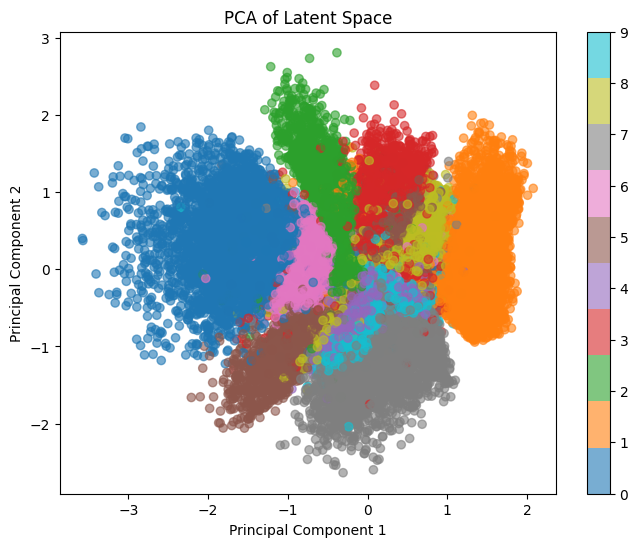

In [ ]:
pca = PCA(n_components=2)
latent_pca = pca.fit_transform(latent_vectors)

plt.figure(figsize=(8, 6))
plt.scatter(latent_pca[:, 0], latent_pca[:, 1], c=labels, cmap='tab10', alpha=0.6)
plt.colorbar()
plt.title("PCA of Latent Space")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


### 10 newly generated images

In [ ]:
#dictionary to store latent vectors for each digit
latent_dict = {i: [] for i in range(10)}

model.eval()

with torch.no_grad():
    for images, targets in loader:
        images = images.view(images.size(0), 784).to(device)
        mean, logvar = model.encode(images)
        z = model.reparameterization(mean, logvar)

        for i in range(images.size(0)):
            digit_label = targets[i].item()
            latent_dict[digit_label].append(z[i].cpu().numpy())

#convert lists to NumPy arrays
for key in latent_dict:
    latent_dict[key] = np.array(latent_dict[key])


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


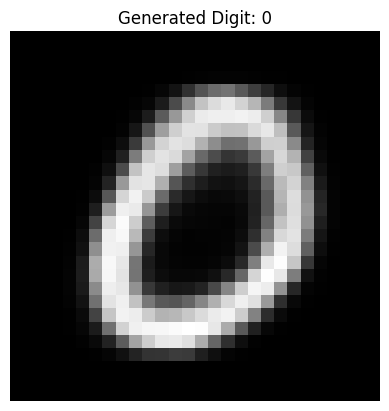

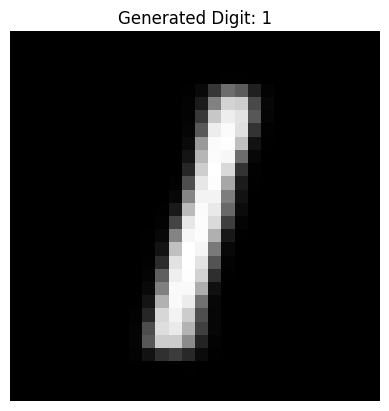

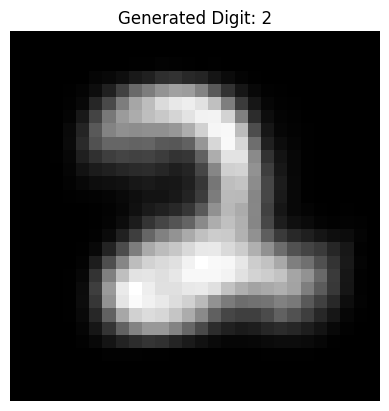

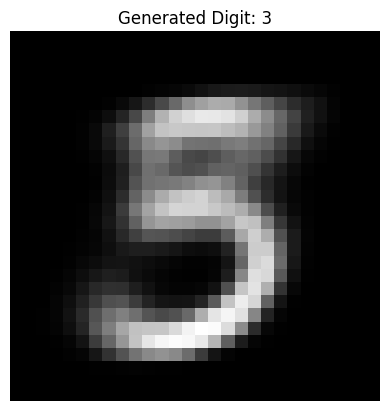

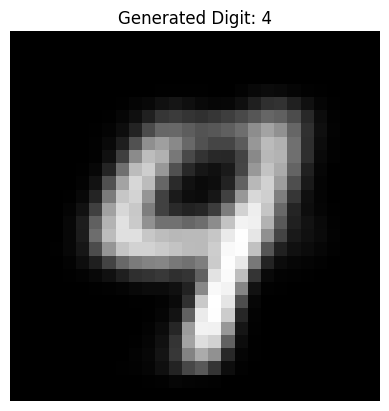

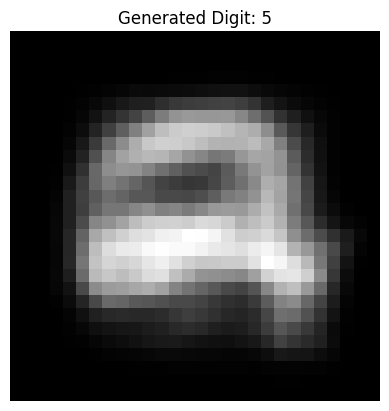

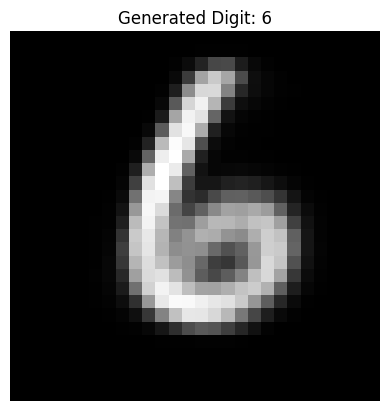

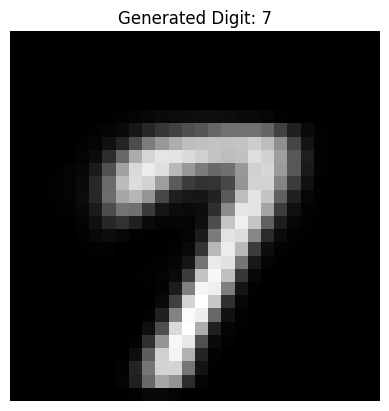

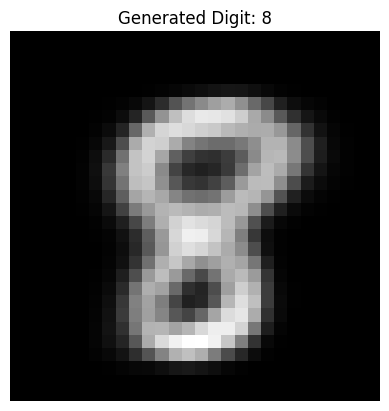

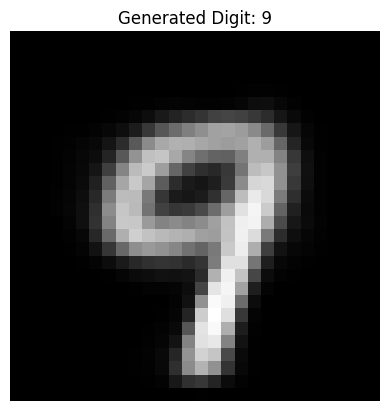

In [ ]:
for i in range(10):
    generate_image(model, digit=i, latent_dict=latent_dict, mean_type='average')

### 5 images of second last roll num digit i.e '8'

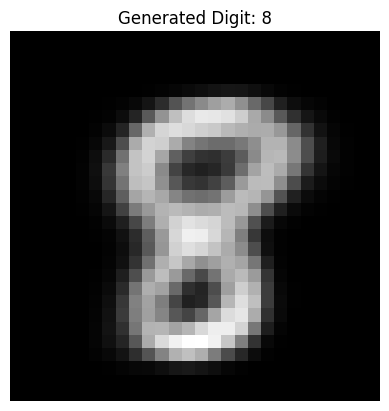

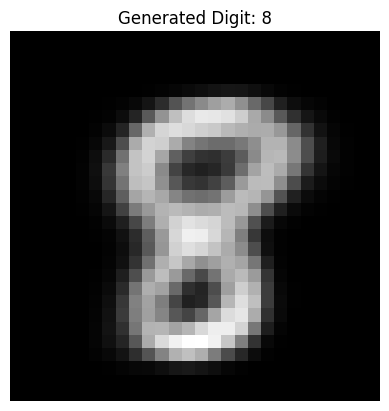

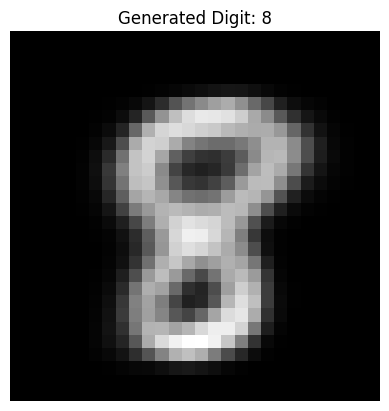

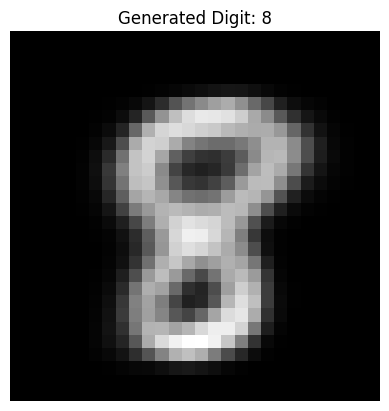

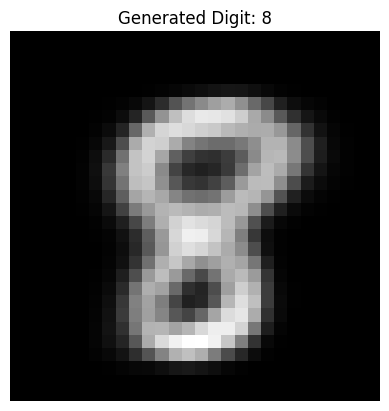

In [ ]:
for i in range(5):
    generate_image(model, digit=8, latent_dict=latent_dict, mean_type='average')

## MNIST Fashion

In [29]:
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

data = datasets.FashionMNIST(root='./data_src', train=True, download=True, transform=transform)

loader = DataLoader(dataset=data, batch_size=100, shuffle=True, num_workers=20)

In [30]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train(model, optimizer, epochs=50)


	Epoch 1 	Average Loss:  0.005186079987883568
	Epoch 2 	Average Loss:  0.00464887263327837
	Epoch 3 	Average Loss:  0.004255781550705433
	Epoch 4 	Average Loss:  0.004188337909181912
	Epoch 5 	Average Loss:  0.003913095640639464
	Epoch 6 	Average Loss:  0.006754481571912765
	Epoch 7 	Average Loss:  0.004295152023931345
	Epoch 8 	Average Loss:  0.00392328445315361
	Epoch 9 	Average Loss:  0.0037821501851081846
	Epoch 10 	Average Loss:  0.0036905022059877716
	Epoch 11 	Average Loss:  0.0036283051908016207
	Epoch 12 	Average Loss:  0.0037713581512371698
	Epoch 13 	Average Loss:  0.0035742939348022145
	Epoch 14 	Average Loss:  0.003540096802512805
	Epoch 15 	Average Loss:  0.004704333654046058
	Epoch 16 	Average Loss:  0.003687773390611013
	Epoch 17 	Average Loss:  0.003595152134199937
	Epoch 18 	Average Loss:  0.0035669766957561176
	Epoch 19 	Average Loss:  0.0035397277186314264
	Epoch 20 	Average Loss:  0.0035188694208860396
	Epoch 21 	Average Loss:  0.004244784853359064
	Epoch 22 	Avera

In [31]:
#extract latent vectors and labels
model.eval()
latent_vectors = []
labels = []

with torch.no_grad():
    for images, targets in loader:
        images = images.view(images.size(0), 784).to(device)  #flatten input
        mean, logvar = model.encode(images)  #latent representation
        z = model.reparameterization(mean, logvar)  #sampled latent vectors

        latent_vectors.append(z.cpu().numpy())
        labels.append(targets.numpy())

latent_vectors = np.concatenate(latent_vectors, axis=0)
labels = np.concatenate(labels, axis=0)

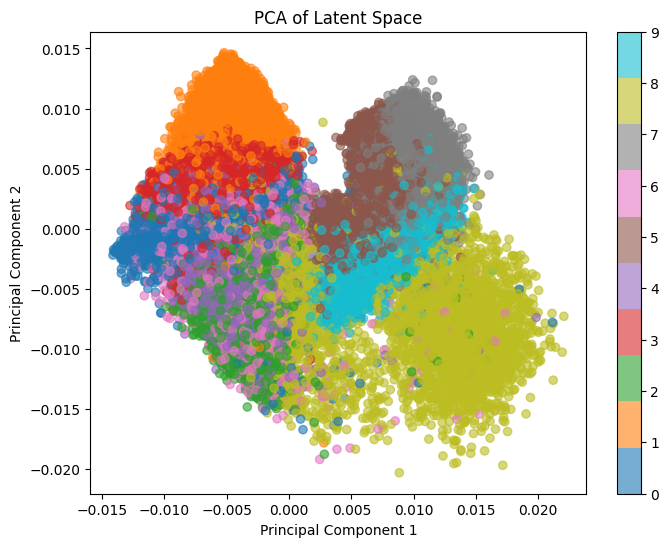

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
latent_pca = pca.fit_transform(latent_vectors)

plt.figure(figsize=(8, 6))
plt.scatter(latent_pca[:, 0], latent_pca[:, 1], c=labels, cmap='tab10', alpha=0.6)
plt.colorbar()
plt.title("PCA of Latent Space")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


### 10 newly generated images

In [32]:
#dictionary to store latent vectors for each digit
latent_dict = {i: [] for i in range(10)}

model.eval()

with torch.no_grad():
    for images, targets in loader:
        images = images.view(images.size(0), 784).to(device)
        mean, logvar = model.encode(images)
        z = model.reparameterization(mean, logvar)

        for i in range(images.size(0)):
            digit_label = targets[i].item()
            latent_dict[digit_label].append(z[i].cpu().numpy())

#convert lists to NumPy arrays
for key in latent_dict:
    latent_dict[key] = np.array(latent_dict[key])

<ipython-input-22-de30952e367e>:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  z_sample = torch.tensor([z_sample], dtype=torch.float32).to(device) #convert latent vaector to tensor


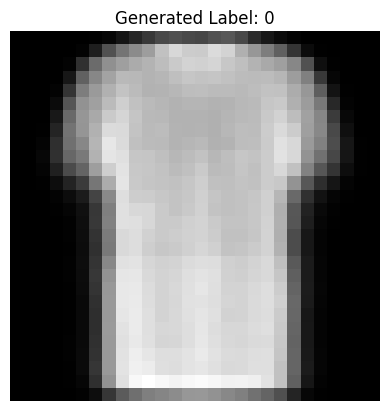

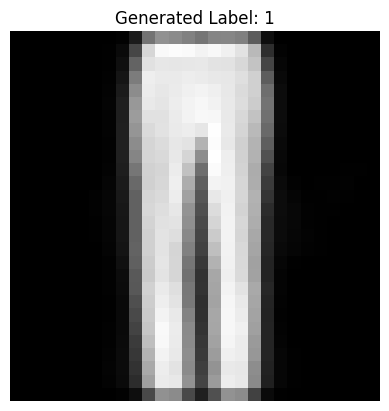

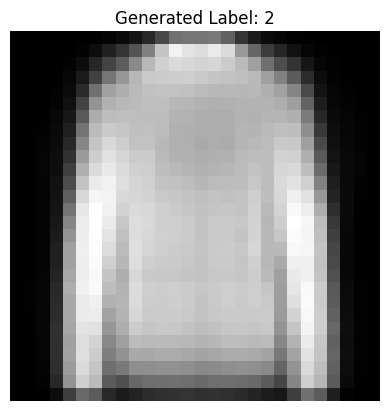

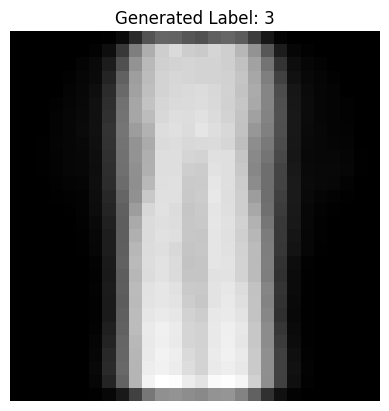

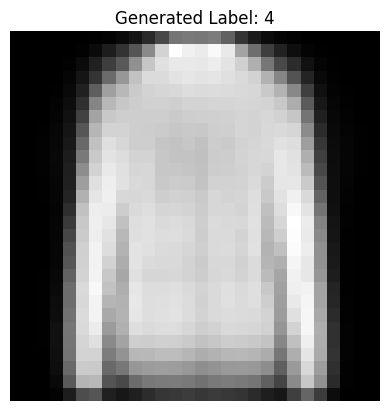

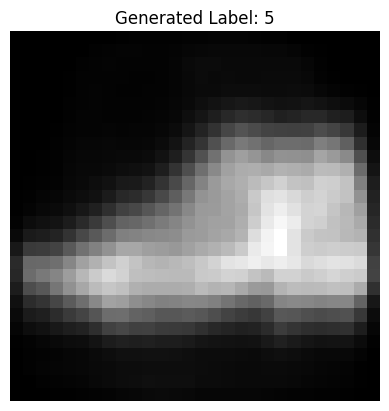

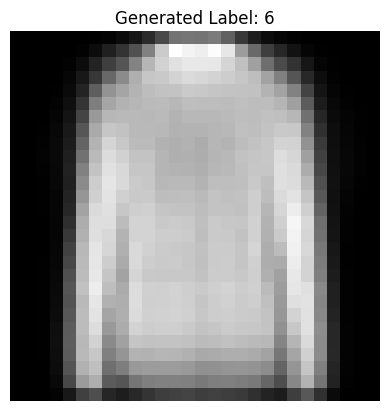

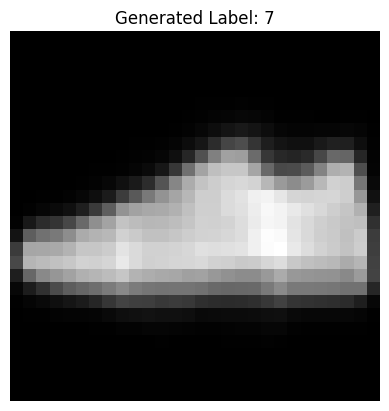

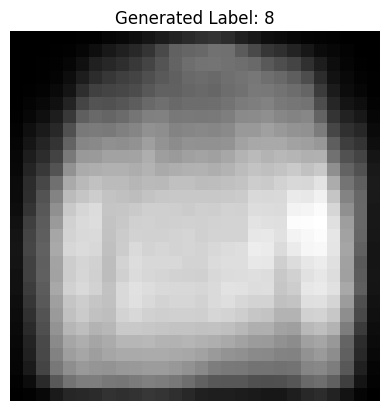

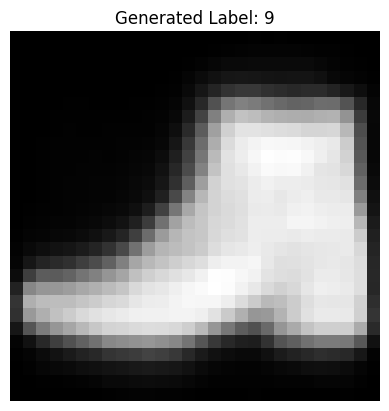

In [33]:
for i in range(10):
    generate_image(model, digit=i, latent_dict=latent_dict, mean_type='average')

# Part 4: Comparison and Analysis

## a) Image Quality

GAN produced better quality digits as the generated images were sharp and had variation. Images generated by VAE were comparatively blurrier.

## b) Training stability

GAN was harder to train as it has min-max game between generator and discriminator. If discriminator becomes too strong then generator receives no meaningful gradients. If the generator becomes too strong then discriminator fails to guide learning, leading to mode collapse.

## c) Latent Space Representation

GANs have unstructured and non-continuous latent space. The generator maps random noise to realistic samples, but without an explicit constraint on how points in the latent space are structured. Interpolating between points in latent space might generate unrealistic images. Similar images might not be close in latent space, making representation learning harder. 

VAE have structured and continuous latent space. VAEs enforce a structured latent space using KL divergence to make the learned distribution resemble a standard normal distribution.

## Potential Improvements:

We can use larger latent vector in GAN to increase variability in generated images. We can use different optimizer and learning rates in GAN. We can also change Leaky RELU penalty factor as well as the Dropout value.

For VAE, we can increase the size of latent vector to store better representation. We can use ELU instead of Leaky RELU for smoother gradient flow. We can also use different optimizer and learning rates.